In [4]:
import pandas as pd
import os.path as op
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
import os
from numrisk.utils.data import Subject

bids_folder = '/Volumes/mrenkeED/data/ds-dnumrisk'
subs= [int(f[4:]) for f in listdir(bids_folder) if f[0:3] == 'sub']
pati_save = '/Users/mrenke/data/ds-dnumrisk/interim_sum_data'

target_folder = op.join(bids_folder, 'derivatives', 'cogmodels')
subjects = [Subject(sub, bids_folder) for sub in subs]



In [6]:
from bauer.models import MagnitudeComparisonModel
import arviz as az

target_accept = 0.9
burnin=1000
samples=1000

In [2]:
# single, for model-vis
from pymc import model_graph # needs graphviz which is only installed in behav_fit2 !

split_data = 'run_456'
runs = range(4,7)

behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
behavior = pd.concat(behavior).sort_index(0)

df = behavior.dropna()
df['choice'] = df['chose_n2']

model = MagnitudeComparisonModel(df, fit_seperate_evidence_sd = True)
model.build_estimation_model()
model_graph.model_to_graphviz(model=model.estimation_model)

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_82417/1763774174.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  behavior = pd.concat(behavior).sort_index(0)


In [7]:
# loop 

fit_prior = True
evisd = True # fit_seperate_evidence_sd

data_variants = ['full', 'run_123', 'run_456']

for split_data in data_variants:
    if split_data == 'full':
        runs = range(1, 7)
    if split_data == 'run_123':
        runs = range(1, 4)
    elif split_data == 'run_456':
        runs = range(4,7)

    behavior = [s.get_behavior_magjudge(runs = runs) for s in subjects]
    df =  pd.concat(behavior).sort_index(0).dropna()
    df['choice'] = df['chose_n2']

    model = MagnitudeComparisonModel(df, fit_prior=fit_prior, fit_seperate_evidence_sd = evisd )
    model.build_estimation_model()
    trace = model.sample(burnin, samples, target_accept=target_accept)

    fit_prior = 'fit' if fit_prior else 'obj'
    evisd = 'sep' if evisd else 'same'
    az.to_netcdf(trace,
                    op.join(target_folder, f'model-{split_data}_prior-{fit_prior}_evisd-{evisd}_trace.netcdf'))
    
    

/var/folders/3k/8g0xv78x051fznwyh_m5xcn8f91w3q/T/ipykernel_84246/1057976836.py:17: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only.
  df =  pd.concat(behavior).sort_index(0).dropna()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [n1_evidence_sd_mu_untransformed, n1_evidence_sd_sd, n1_evidence_sd_offset, n2_evidence_sd_mu_untransformed, n2_evidence_sd_sd, n2_evidence_sd_offset, prior_mu_mu, prior_mu_sd, prior_mu_offset, prior_sd_mu_untransformed, prior_sd_sd, prior_sd_offset]


In [15]:
split_data = 'full'
idata =  az.from_netcdf(op.join(target_folder, f'model-{split_data}_trace.netcdf'))


In [17]:
from bauer.utils.math import softplus_np

data_variants = ['full', 'run_123', 'run_456']
key = ''#_untransformed'# _offset

df_sds = []
for split_data in data_variants:
    idata =  az.from_netcdf(op.join(target_folder, f'model-{split_data}_trace.netcdf'))
    #evidence_sd = pd.concat((idata.posterior['n1_evidence_sd_mu'].to_dataframe(), (idata.posterior['n2_evidence_sd_mu'].to_dataframe())), axis=1)
    evidence_sd = pd.concat((idata.posterior[f'n1_evidence_sd{key}'].to_dataframe(), (idata.posterior[f'n2_evidence_sd{key}'].to_dataframe())), axis=1)
    evidence_sd.columns.name = 'parameter'
    evidence_sd = evidence_sd.stack().to_frame('value')
    evidence_sd['Noise'] = evidence_sd.index.get_level_values('parameter').map({f'n1_evidence_sd{key}':'n1', f'n2_evidence_sd{key}':'n2'})
    evidence_sd = evidence_sd.set_index('Noise', append=True)
    evidence_sd['value_softpl'] = softplus_np(evidence_sd['value'])
    df_sds.append(evidence_sd.groupby(['subject','Noise'])['value_softpl'].mean()) # 


df_sds = pd.concat(df_sds, keys=data_variants, names=['data','subject','order']).to_frame('sd')

df_sds.to_csv(op.join(pati_save, 'sds_sub1-42_data-variants.csv'))

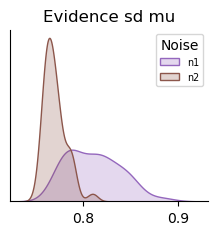

In [18]:

temp = df_sds.xs('full',0,'data')
fac = sns.FacetGrid(temp.reset_index(), hue='order', palette=sns.color_palette()[4:], aspect=1.1, height=2.5)
fac.map(sns.kdeplot, 'sd', fill=True)
fac.set(xlabel=None, ylabel=None, yticks=[])
plt.title('Evidence sd mu')
plt.legend(title='Noise',loc='upper right',fontsize='x-small')


In [12]:
# load in 

df_sds = pd.read_csv(op.join(pati_save, 'sds_sub1-42_data-variants.csv'))
df_sds = df_sds.set_index(['data','subject','order'])

df_rs = pd.read_csv(op.join(pati_save, 'rs_sub1-42_data-variants.csv'))

In [14]:
df_sds.head()

sd
data subject order          
full 1       n1     0.177702
             n2     0.142251
     2       n1     0.271972
             n2     0.152757
     3       n1     0.303147

In [17]:
df_comb = df_sds.xs('n2',0,'order').join(df_rs.set_index(['data','subject']))
df_comb = df_comb.dropna()

In [18]:
df_comb.head()

sd         r
data subject                    
full 2        0.152757  0.207033
     5        0.181419 -0.023740
     6        0.144508  0.062036
     7        0.158677  0.087489
     8        0.123607  0.262900

Text(0.5, 1.0, ' r=0.16, p= 0.33924')

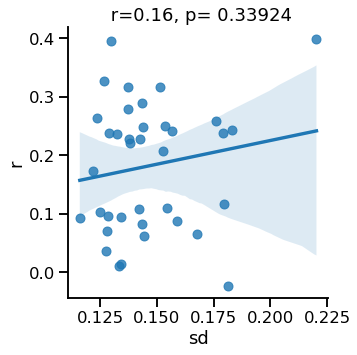

In [22]:
import pingouin 
sns.set_context('talk')

temp = df_comb.xs('full',0,'data')

var1 = 'sd' #'run_456' # 
var2 = 'r'
cor = pingouin.corr(temp[var1],temp[var2])
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 5)

sns.lmplot(data=temp, x=var1,y=var2)
plt.title(f' r={r_}, p= {p}') 